# Transformer from Scratch: A Deep Dive

## 1. Introduction
In this notebook, building a **Transformer** model from scratch using PyTorch. The goal is to understand the inner workings of the architecture proposed in the seminal paper *"[Attention Is All You Need](https://arxiv.org/abs/1706.03762)"* (Vaswani et al., 2017).

While the original paper proposes an Encoder-Decoder architecture for Machine Translation,this notebook will focus on a **Decoder-only** architecture (similar to GPT). This is the standard architecture for Generative AI and Large Language Models (LLMs) today.

### Objective
Train a character-level language model on the **Tiny Shakespeare** dataset. The model will learn to generate text that looks like Shakespeare.

### Key Concepts Covered
1.  **Self-Attention**: The core mechanism allowing the model to weigh the importance of different tokens.
2.  **Multi-Head Attention**: Running multiple attention mechanisms in parallel.
3.  **Feed-Forward Networks**: Processing information individually at each position.
4.  **Residual Connections & Layer Normalization**: Techniques for stable training of deep networks.
5.  **Positional Embeddings**: Injecting order information into the sequence.



In [ ]:
#Liveloss plot to visualize the loss
!pip install livelossplot gradio

In [ ]:
#Set to False if not pushing to hub
PUSH_TO_HUB = True

from huggingface_hub import notebook_login
if PUSH_TO_HUB:
  notebook_login()

In [ ]:
import torch
import torch.nn as nn
from torch.nn import functional as F
import requests
from datasets import load_dataset
import torch
import json
from livelossplot import PlotLosses
from huggingface_hub import HfApi
import gradio as gr

In [ ]:
# Hyperparameters
batch_size = 64
block_size = 256
max_iters = 3000
eval_interval = 50
learning_rate = 3e-4
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 200
n_embd = 384
n_head = 6
n_layer = 6
dropout = 0.2
# ------------

torch.manual_seed(1337)
print(f"Using device: {device}")

Using device: cuda


## 2. Data Preparation
The Tiny Shakespeare dataset is used in this study. The dataset is first downloaded and the text content is inspected.

A simple Tokenizer is constructed. As this is a character-level model, the vocabulary consists of all unique characters in the text. Each character is mapped to a corresponding integer.

In [ ]:
# # Download the dataset
!wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt

# Read the dataset
with open('input.txt', 'r', encoding='utf-8') as f:
    text = f.read()

# Create Vocabulary
chars = sorted(list(set(text)))
vocab_size = len(chars)

# Create Mappings
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
encode = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
decode = lambda l: ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string

print(f"Vocabulary Size: {vocab_size}")
print(f"Vocabulary: {''.join(chars)}")

# Train/Val Split
data = torch.tensor(encode(text), dtype=torch.long)
n = int(0.9*len(data))
train_data = data[:n]
val_data = data[n:]

# Data Loading Function
def get_batch(split):
    # generate a small batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y

# Loss Estimation Helper
@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out


--2025-11-30 13:36:28--  https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1115394 (1.1M) [text/plain]
Saving to: ‘input.txt’

input.txt           100%[===================>]   1.06M  --.-KB/s    in 0.03s   

2025-11-30 13:36:28 (37.6 MB/s) - ‘input.txt’ saved [1115394/1115394]

Vocabulary Size: 65
Vocabulary: 
 !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz


## 3. The Transformer Architecture
The Transformer replaces Recurrent Neural Networks (RNNs) with an architecture based entirely on **Attention**.

### 3.1 Self-Attention (The "Communication" Mechanism)
In the paper "Attention Is All You Need", the attention mechanism is described as **Scaled Dot-Product Attention**:

$$
Attention(Q, K, V) = softmax(\frac{QK^T}{\sqrt{d_k}})V
$$

Where:
*   **Q (Query)**: What am I looking for?
*   **K (Key)**: What do I contain?
*   **V (Value)**: What information do I pass if I am selected?

In our **Decoder** block,**Masked Self-Attention** is used. The mask ensures that a token at position $t$ can only attend to positions $\le t$ (past tokens), preserving the autoregressive property.

Below is the implementation of a single Head of self-attention.



In [ ]:
class Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B,T,C = x.shape
        k = self.key(x)
        q = self.query(x)

        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2,-1) * C**-0.5

        # Masking: ensure we don't look into the future
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)

        wei = F.softmax(wei, dim=-1) # (B, T, T)
        wei = self.dropout(wei)

        # perform the weighted aggregation of the values
        v = self.value(x)
        out = wei @ v
        return out


### 3.2 Multi-Head Attention
The paper states: *"Multi-head attention allows the model to jointly attend to information from different representation subspaces at different positions."*

Instead of a single attention head, we run multiple heads in parallel and concatenate their outputs. This gives the model multiple "perspectives" on the data.



In [ ]:
class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(n_embd, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out


### 3.3 Feed-Forward Network (The "Computation" Mechanism)
After the attention mechanism (communication), each token processes the information independently using a Feed-Forward Network. This is a simple Multi-Layer Perceptron (MLP).



In [ ]:
class FeedFoward(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)


### 3.4 The Transformer Block
A single Transformer Block consists of:
1.  Multi-Head Attention
2.  Feed-Forward Network
3.  **Layer Normalization** applied before each sub-layer (Pre-Norm formulation, common in GPT).
4.  **Residual Connections** (Skip connections) added after each sub-layer.

$$
x = x + Attention(LayerNorm(x)) \\
x = x + MLP(LayerNorm(x))
$$



In [ ]:
class Block(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, n_embd, n_head):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedFoward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x


## 4. The Full GPT Model
The full model.
1.  **Token Embeddings**: Convert integer indices to vectors.
2.  **Positional Embeddings**: Since attention has no notion of order, we add learnable position vectors.
3.  **Transformer Blocks**: A stack of `n_layer` blocks.
4.  **Final Layer Norm**: Normalization before the final projection.
5.  **Language Model Head**: Projects back to vocabulary size to get logits for the next token.



In [ ]:
%%writefile model.py
import torch
import torch.nn as nn
from torch.nn import functional as F
from huggingface_hub import PyTorchModelHubMixin

# --- Architecture Definition ---

class Head(nn.Module):
    """ one head of self-attention """
    def __init__(self, head_size, n_embd, block_size, dropout):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B,T,C = x.shape
        k = self.key(x)
        q = self.query(x)
        wei = q @ k.transpose(-2,-1) * C**-0.5
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf'))
        wei = F.softmax(wei, dim=-1)
        wei = self.dropout(wei)
        v = self.value(x)
        out = wei @ v
        return out

class MultiHeadAttention(nn.Module):
    def __init__(self, num_heads, head_size, n_embd, block_size, dropout):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size, n_embd, block_size, dropout) for _ in range(num_heads)])
        self.proj = nn.Linear(n_embd, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

class FeedFoward(nn.Module):
    def __init__(self, n_embd, dropout):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)

class Block(nn.Module):
    def __init__(self, n_embd, n_head, block_size, dropout):
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size, n_embd, block_size, dropout)
        self.ffwd = FeedFoward(n_embd, dropout)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x

# --- The Main Model ---
# We inherit from PyTorchModelHubMixin to enable push_to_hub
class GPTLanguageModel(nn.Module, PyTorchModelHubMixin):
    def __init__(self, vocab_size, n_embd, n_head, n_layer, block_size, dropout):
        super().__init__()
        self.block_size = block_size
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[
            Block(n_embd, n_head, block_size, dropout) for _ in range(n_layer)
        ])
        self.ln_f = nn.LayerNorm(n_embd)
        self.lm_head = nn.Linear(n_embd, vocab_size)

    def forward(self, idx, targets=None):
        B, T = idx.shape
        device = idx.device
        tok_emb = self.token_embedding_table(idx)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device))
        x = tok_emb + pos_emb
        x = self.blocks(x)
        x = self.ln_f(x)
        logits = self.lm_head(x)

        loss = None
        if targets is not None:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        for _ in range(max_new_tokens):
            idx_cond = idx[:, -self.block_size:]
            logits, _ = self(idx_cond)
            logits = logits[:, -1, :]
            probs = F.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1)
            idx = torch.cat((idx, idx_next), dim=1)
        return idx

Writing model.py


## 5. Training
Instantiate the model, move it to the GPU (if available), and train it using the **AdamW** optimizer.



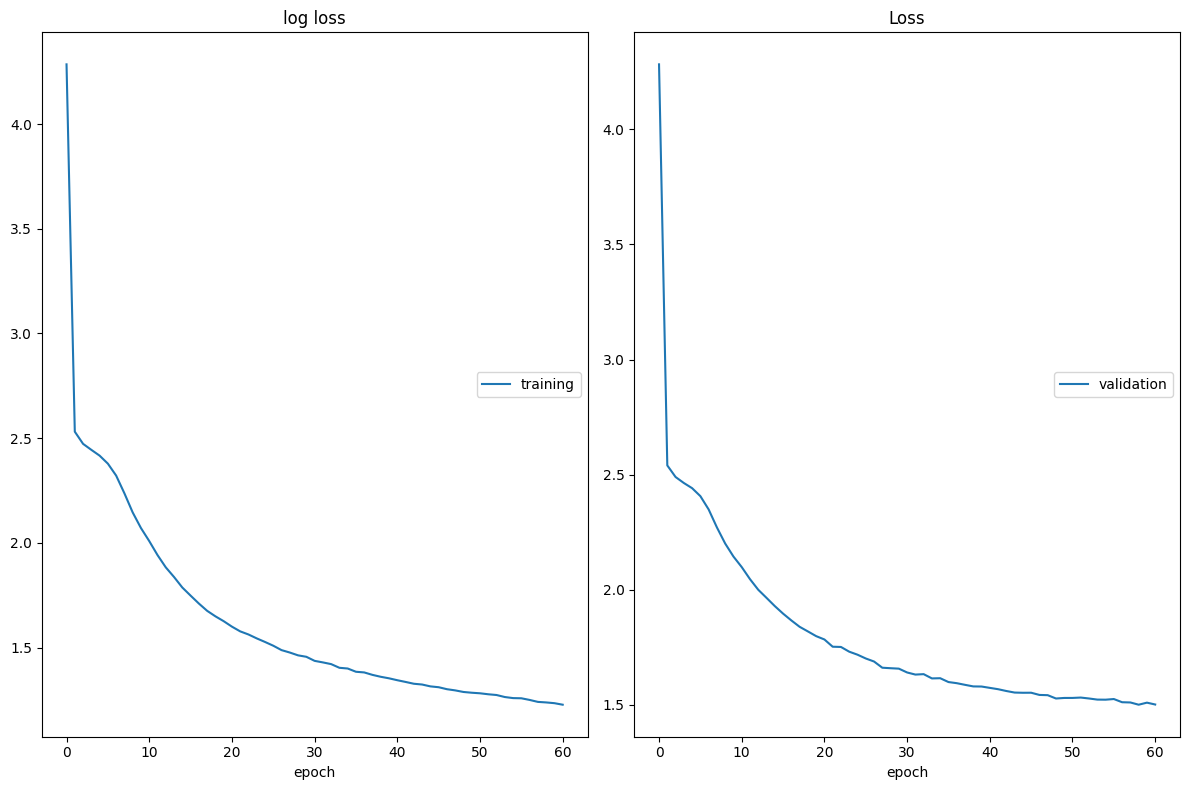

log loss
	training         	 (min:    1.227, max:    4.285, cur:    1.227)
Loss
	validation       	 (min:    1.501, max:    4.282, cur:    1.502)


In [ ]:
from model import GPTLanguageModel
from livelossplot import PlotLosses

model = GPTLanguageModel(vocab_size, n_embd, n_head, n_layer, block_size, dropout)
m = model.to(device)


# Initialize the plotter
liveloss = PlotLosses()

# Initialize Optimizer (if not already done)
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

print("Starting training...")

for iter in range(max_iters):

    # every once in a while evaluate the loss on train and val sets
    if iter % eval_interval == 0 or iter == max_iters - 1:
        losses = estimate_loss()

        # --- LIVELOSS UPDATE ---
        liveloss.update({
            'log loss': losses['train'].item(), # Training loss
            'val_loss': losses['val'].item()    # Validation loss
        })
        liveloss.send()

    # sample a batch of data
    xb, yb = get_batch('train')

    # evaluate the loss
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()


## 6. Evaluation & Generation
After training, the model is used to generate Shakespeare-like text.



In [ ]:
# generate from the model
context = torch.zeros((1, 1), dtype=torch.long, device=device)
print(decode(m.generate(context, max_new_tokens=2000)[0].tolist()))



O live you shall! as, why not?

HENRY BOLINGBROKE:
Ay, less to detell me;
And yet yet I hear King Towerfollo.

HENRY BOLINGBROKE:
The muter of the reape music,
What satisfy you, marriest! let heaven,
This call them labour to spure to his consu toward
And cannot, go will that the wido hairy.

MERCUTIO:
Nay, take sale there so! had very
with it abadle me; this face, art with Bondon Polixenes,
Is very carnst are no world.

Where one all his contry of England for't, nor
appecilents, nothing horrow.

BALLO:
They will come hither tongues.

AUTOLYCUS:
I'ld none battle.

CORIOLANUS:
Your shall not forgate till I show he have done
To fought our hearts an her true.

CORIOLANUS:
A come, Pickolizen:
Well, o'er help wear, here and
We on his good tell.

LORD RIVERS:
This arm, as it is goodly assue: hih, and be mothes
Of comfort: treasons are lack, your less in the wars of
Lady is fa, warme beat is brother and
down. Whele it seek of the constraite of bring
felf, whom go false upon the eyes he told
o

### Save model to huggingface
Save time by pushing model to easily reload and make inference
You do not need to run this cell if you are only testing

In [ ]:
repo_id = "Ajegetina/my-shakespeare-gpt"

# A. Push Model Weights & Config
model.push_to_hub(repo_id)

# B. Push Vocabulary
vocab_dict = {'stoi': stoi, 'itos': itos}
with open("vocab.json", "w") as f:
    json.dump(vocab_dict, f)

api = HfApi()
api.upload_file(
    path_or_fileobj="vocab.json",
    path_in_repo="vocab.json",
    repo_id=repo_id,
    repo_type="model"
)

print(f"Successfully pushed to https://huggingface.co/{repo_id}")

Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ...are-gpt/model.safetensors:   0%|          | 12.4kB / 52.6MB            

No files have been modified since last commit. Skipping to prevent empty commit.


Successfully pushed to https://huggingface.co/Ajegetina/my-shakespeare-gpt


#### Using deployed model
Run this cell if you want to use the pushed model

In [ ]:
from huggingface_hub import hf_hub_download
from model import GPTLanguageModel

# 2. SETUP
device = 'cuda' if torch.cuda.is_available() else 'cpu'
repo_id = "Ajegetina/my-shakespeare-gpt"

# 3. DOWNLOAD & LOAD VOCAB
vocab_path = hf_hub_download(repo_id=repo_id, filename="vocab.json")
with open(vocab_path, 'r') as f:
    vocab = json.load(f)
    stoi = vocab['stoi']
    itos = {int(k): v for k, v in vocab['itos'].items()}

# 4. LOAD MODEL (Weights + Config)
model = GPTLanguageModel.from_pretrained(repo_id)
model.to(device)
model.eval()

In [ ]:
# 4. DEFINE GENERATION FUNCTION
def generate_text(prompt, max_length=100):
    if not prompt.strip():
        prompt = " "

    # Encode
    input_ids = [stoi.get(c, stoi.get(' ')) for c in prompt]
    idx = torch.tensor(input_ids, dtype=torch.long, device=device).unsqueeze(0)

    # Generate
    with torch.no_grad():
        output_ids = model.generate(idx, max_new_tokens=int(max_length))

    # Decode
    return ''.join([itos[i] for i in output_ids[0].tolist()])

# 5. LAUNCH UI
with gr.Blocks(theme=gr.themes.Soft()) as demo:
    gr.Markdown(f"# 🎭 Shakespeare GPT")
    gr.Markdown(f"Running model pulled from: [{repo_id}](https://huggingface.co/{repo_id})")

    with gr.Row():
        inp = gr.Textbox(label="Prompt", placeholder="The king said", lines=2)
        slider = gr.Slider(10, 500, value=100, label="Max Characters")

    out = gr.Textbox(label="Generated Text", lines=8)

    btn = gr.Button("Generate")
    btn.click(generate_text, inputs=[inp, slider], outputs=out)

demo.launch(share=True)

/tmp/ipython-input-1401653741.py:18: DeprecationWarning: The 'theme' parameter in the Blocks constructor will be removed in Gradio 6.0. You will need to pass 'theme' to Blocks.launch() instead.
  with gr.Blocks(theme=gr.themes.Soft()) as demo:


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://e692952e23bddf066d.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
